In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import random
from typing import Tuple

In [4]:
import matplotlib.pyplot as plt
import scipy.sparse as spp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import dgl
from dgl.nn.pytorch import GraphConv

Using backend: pytorch


In [5]:
import src.config as global_config
import src.virus_simulation.config as simulation_config
from src.virus_simulation.snapshot_parsing import Snapshot
from src.utils.iterables import sliding_window

# Experiment description

We are going to generate graph dataset of virus expansion in a population (as described in README.md). Then we are aim to prepare POC showing that with use of DGL and graph convolutional network (GCN) it is possible to detect people that may be sick on the basis of record of contacts between people when we are able to obtain a dose of tests results which serves as a base for semi-supervised training.

Our virus expansion model is basically very simple, as well as GCN we intend to use. Worth noting is a fact that we make use of not-discrete adjacency matix constructed in following way:

$A_{i,j} = min(\sum_c^{contacts}c.intensity, 1.0)$

Thanks to that we aim to inject a level of exposure of a particular simulated individual into model training.

What we cannot achieve with this model is to inject temporal dimension - this would be possible if something like _time-wise graph convolutions_ were implemented somehow in DGL, as the contact is dangerous only if one persion is sick - and two meetings of the same people in different time stamps may have significantly different context.

In [6]:
SIMULATION_SNAPSHOT_PATH = os.path.join(
    global_config.VIRUS_SIMULATION_OUTPUT_PATH,
    "test_simulation_snapshot_299.json"
)

In [7]:
SIMULATION_SNAPSHOT = Snapshot.initialize(
    snapshot_path=SIMULATION_SNAPSHOT_PATH
)

## Visualisation of simulated people traces

In [8]:
def show_random_traces(snapshot: Snapshot,
                       max_traces_to_show: int
                      ) -> None:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    traces = list(SIMULATION_SNAPSHOT.traces.values())
    random.shuffle(traces)
    traces = traces[:max_traces_to_show]
    for trace in traces:
        plt.plot(trace[0], trace[1], linestyle="-", linewidth=0.2, marker=None)
    plt.show()

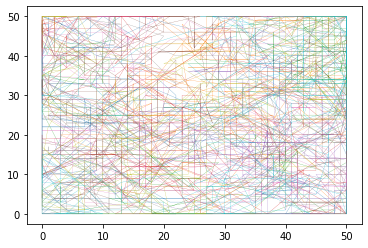

In [9]:
show_random_traces(
    snapshot=SIMULATION_SNAPSHOT,
    max_traces_to_show=10
)

## Graph building

In [10]:
def build_adjacency_matrix(snapshot: Snapshot, 
                           shape: Tuple[int, int]
                          ) -> spp.coo_matrix:
    data = {}
    for contact in snapshot.contacts:
        pair = tuple(contact[simulation_config.CONTACT_PAIR_KEY])
        reversed_pair = pair[1], pair[0]
        contact_duration = contact[simulation_config.CONTACT_DURATION_KEY]
        if pair not in data:
            data[pair] = contact_duration
            data[reversed_pair] = contact_duration
        else:
            data[pair] = min(data[pair] + contact_duration, 1.0)
            data[reversed_pair] = min(data[reversed_pair] + contact_duration, 1.0)
    data, u, v = list(zip(*((d, p[0], p[1]) for p, d in data.items())))
    return spp.coo_matrix((data, (u, v)), shape=shape)

In [11]:
adjacency_matrix = build_adjacency_matrix(SIMULATION_SNAPSHOT, shape=(50, 50))

In [12]:
graph = dgl.DGLGraph()
graph.from_scipy_sparse_matrix(spmat=adjacency_matrix)

## Visualisation of Ground-Truth graph

In [13]:
node_colors = [
    "red" if person[simulation_config.SICKNESS_STATUS_KEY] else "green"
    for person in SIMULATION_SNAPSHOT.people
]

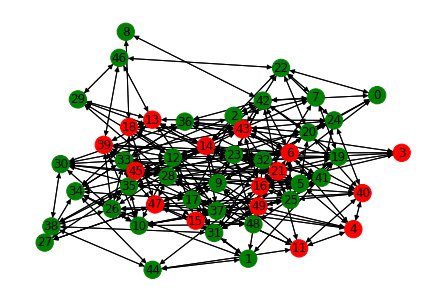

In [14]:
nx.draw(graph.to_networkx(), with_labels=True, node_color=node_colors)

## Model construction

In [15]:
embeddings = nn.Embedding(len(SIMULATION_SNAPSHOT.people), 16)
graph.ndata['features'] = embeddings.weight

In [16]:
def get_n_sick_nodes(snapshot: Snapshot,
                     n: int
                     ) -> Tuple[torch.Tensor, torch.Tensor]:
    return sample_n_nodes(
        snapshot=snapshot,
        n=n,
        sick_status=True
    )


def get_n_healthy_nodes(snapshot: Snapshot,
                        n: int
                        ) -> Tuple[torch.Tensor, torch.Tensor]:
    return sample_n_nodes(
        snapshot=snapshot,
        n=n,
        sick_status=False
    )


def sample_n_nodes(snapshot: Snapshot, 
                   n: int, 
                   sick_status: bool
                  ) -> Tuple[torch.Tensor, torch.Tensor]:
    chosen_people = [
        p[simulation_config.PERSON_ID_KEY] 
        for p in snapshot.people 
        if p[simulation_config.SICKNESS_STATUS_KEY] is sick_status
    ]
    random.shuffle(chosen_people)
    chosen_people = chosen_people[:n]
    labels = [1 if sick_status else 0] * len(chosen_people)
    return torch.Tensor(chosen_people).long(), torch.Tensor(labels).long()

In [17]:
healthy_nodes, healthy_labels = get_n_healthy_nodes(SIMULATION_SNAPSHOT, 4)
sick_nodes, sick_labels = get_n_sick_nodes(SIMULATION_SNAPSHOT, 4)

In [18]:
healthy_nodes, healthy_labels, sick_nodes, sick_labels

(tensor([33, 30, 19, 26]),
 tensor([0, 0, 0, 0]),
 tensor([15,  3,  4, 49]),
 tensor([1, 1, 1, 1]))

In [19]:
labeled_nodes = torch.cat((healthy_nodes, sick_nodes), 0)
labels = torch.cat((healthy_labels, sick_labels), 0)

In [20]:
labeled_nodes, labels

(tensor([33, 30, 19, 26, 15,  3,  4, 49]), tensor([0, 0, 0, 0, 1, 1, 1, 1]))

In [21]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_sizes, num_classes):
        super(GCN, self).__init__()
        self.input_conv = GraphConv(in_feats, hidden_sizes[0])
        self.convs = [
            GraphConv(input_features, output_features)
            for input_features, output_features 
            in sliding_window(hidden_sizes)
        ]
        self.cls_conv = GraphConv(hidden_sizes[-1], num_classes)

    def forward(self, g, inputs):
        h = self.input_conv(g, inputs)
        h = torch.relu(h)
        for conv in self.convs:
            h = torch.relu(conv(g, h))
        h = self.cls_conv(g, h)
        return h

net = GCN(16, [32, 64, 32], 2)

In [22]:
inputs = embeddings.weight

## Training

In [23]:
# Training loop from https://docs.dgl.ai/en/0.4.x/tutorials/basics/1_first.html


import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embeddings.parameters()), lr=0.01)
all_logits = []
for epoch in range(80):
    logits = net(graph, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6987
Epoch 1 | Loss: 0.6937
Epoch 2 | Loss: 0.6917
Epoch 3 | Loss: 0.6903
Epoch 4 | Loss: 0.6890
Epoch 5 | Loss: 0.6876
Epoch 6 | Loss: 0.6859
Epoch 7 | Loss: 0.6838
Epoch 8 | Loss: 0.6815
Epoch 9 | Loss: 0.6790
Epoch 10 | Loss: 0.6764
Epoch 11 | Loss: 0.6736
Epoch 12 | Loss: 0.6705
Epoch 13 | Loss: 0.6672
Epoch 14 | Loss: 0.6633
Epoch 15 | Loss: 0.6591
Epoch 16 | Loss: 0.6543
Epoch 17 | Loss: 0.6491
Epoch 18 | Loss: 0.6435
Epoch 19 | Loss: 0.6374
Epoch 20 | Loss: 0.6307
Epoch 21 | Loss: 0.6234
Epoch 22 | Loss: 0.6153
Epoch 23 | Loss: 0.6067
Epoch 24 | Loss: 0.5974
Epoch 25 | Loss: 0.5875
Epoch 26 | Loss: 0.5766
Epoch 27 | Loss: 0.5650
Epoch 28 | Loss: 0.5523
Epoch 29 | Loss: 0.5387
Epoch 30 | Loss: 0.5241
Epoch 31 | Loss: 0.5085
Epoch 32 | Loss: 0.4920
Epoch 33 | Loss: 0.4746
Epoch 34 | Loss: 0.4562
Epoch 35 | Loss: 0.4374
Epoch 36 | Loss: 0.4177
Epoch 37 | Loss: 0.3979
Epoch 38 | Loss: 0.3774
Epoch 39 | Loss: 0.3569
Epoch 40 | Loss: 0.3362
Epoch 41 | Loss: 0.3155
Ep

## Results visualisation

In [27]:
# Visualisation util from https://docs.dgl.ai/en/0.4.x/tutorials/basics/1_first.html

import matplotlib.animation as animation
import matplotlib.pyplot as plt

nx_G = graph.to_networkx()

def draw(i):
    pos = {}
    colors = []
    for v in range(len(SIMULATION_SNAPSHOT.people)):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append("red" if cls else "green")
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)
    plt.show()

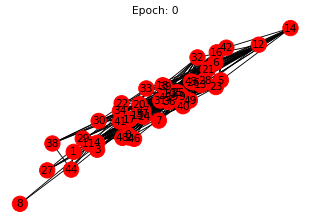

In [30]:
fig = plt.figure(dpi=64)
fig.clf()
ax = fig.subplots()
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

In [31]:
ani.save("animation.mp4")

![](./animation.gif)
   :height: 300px
   :width: 400px
   :align: center



## Checking embedding quality

In [56]:
import numpy as np
from sklearn.manifold import TSNE
X = embeddings.weight.detach().numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)
y = [p[simulation_config.SICKNESS_STATUS_KEY] for p in SIMULATION_SNAPSHOT.people]

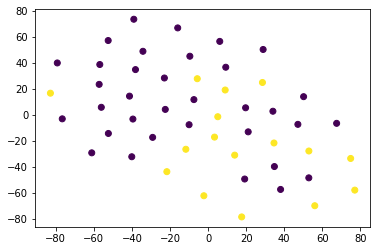

In [57]:
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y)

### Final graph after training

### Ground truth graph

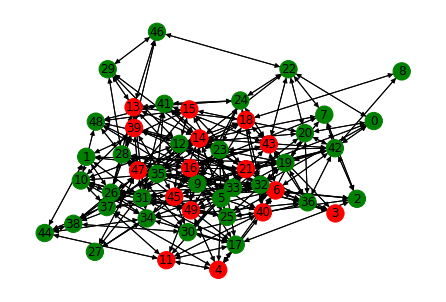

In [85]:
nx.draw(graph.to_networkx(), with_labels=True, node_color=node_colors)
plt.savefig("gt_graph.png")

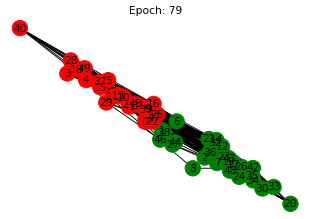

In [60]:
fig = plt.figure(dpi=64)
fig.clf()
ax = fig.subplots()
draw(79)
plt.close()

In [70]:
from sklearn.metrics import confusion_matrix, f1_score
y_true = y
y_pred = [all_logits[79][v].numpy().argmax() for v in range(all_logits[79].shape[0])]
c_matrix = confusion_matrix(y_true, y_pred)

In [64]:
print(c_matrix)

[[23 11]
 [ 4 12]]


In [69]:
tn, fp, fn, tp = c_matrix.ravel()
print("TN: ", tn)
print("FP: ", fp)
print("FN: ", fn)
print("TP: ", tp)

TN:  23
FP:  11
FN:  4
TP:  12


In [71]:
f1_score(y_true, y_pred)

0.6153846153846153

In [73]:
total_sick = len([gt for gt in y_true if gt])

In [77]:
print("TOTAL SICK PEOPLE: ", total_sick)
print("TOTAL PEOPLE: ", len(y_true))
print("SICK PEOPLE FRACTION: ", total_sick / len(y_true))

TOTAL SICK PEOPLE:  16
TOTAL PEOPLE:  50
SICK PEOPLE FRACTION:  0.32


## Conclusions

Thanks to DGL, POC execution was quite easy. Results are not significantly good, but the case is here that both data quality is not well and model as such is by design not capable to grasp the underlying phenomenon. Worth mentioning is fact that DGL implements appropriate GCN layers by-default what makes the process of network design extremally high-level. There are some positive and detrimental implications of such a library design. Simplicity is nice, but when it comes to more sophisticated tasks it may be needed to take a closer look at details. In such case it would be essentialy better to have a little bit less abstraction over whats inside the library.